## <center> Netflix Movie Recommendation System

## Business Problem

<p>Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes.</p>

<p>Now there are a lot of interesting alternative approaches to how Cinematch works that netflix haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business.</p>

<p> Credits: 
    https://www.netflixprize.com/rules.html 
</p>

## Problem Statement
<p>Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training data set. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.)</p>

## Sources
* https://www.netflixprize.com/rules.html
* https://www.kaggle.com/netflix-inc/netflix-prize-data
* Netflix blog: https://medium.com/netflix-techblog/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429 (very nice blog)
* surprise library: http://surpriselib.com/ (we use many models from this library)
* surprise library doc: http://surprise.readthedocs.io/en/stable/getting_started.html (we use many models from this library)
* installing surprise: https://github.com/NicolasHug/Surprise#installation
* Research paper: http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf (most of our work was inspired by this paper)
* SVD Decomposition : https://www.youtube.com/watch?v=P5mlg91as1c

<p><b>Real world/Business Objectives and constraints</b></p> 

<p><b>Objectives:</b></p>
1.	Predict the rating that a user would give to a movie that he has not yet rated.<br>
2.	Minimize the difference between predicted and actual rating (RMSE and MAPE).

#### Constraints:

-  Some form of interpretability.
-  There is no low latency requirement as the recommended movies can be   precomputed earlier.

<p><b>Type of Data:</b></p>
* There are 17770 unique movie IDs.
* There are 480189 unique user IDs.
* There are ratings. Ratings are on a five star (integral) scale from 1 to 5.

<p><b>Data Overview</b></p>
<b>Data files :</b><br>

1. combined_data_1.txt
2. combined_data_2.txt
3. combined_data_3.txt
4. combined_data_4.txt
5. movie_titles.csv
  
The first line of each file [combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt] contains the movie id followed by a colon. Each subsequent line in the file corresponds to a customerID, rating from a customer and its date.

<p style = "font-size: 22px"><b>Example Data Point</b></p>
<pre>
1:
1488844,3,2005-09-06
822109,5,2005-05-13
885013,4,2005-10-19
30878,4,2005-12-26
</pre>

## Mapping the real world problem to a Machine Learning Problem
<p><b>Type of Machine Learning Problem</b></p>
<p>
For a given movie and user we need to predict the rating would be given by him/her to the movie. 
The given problem is a Recommendation problem 
It can also seen as a Regression problem 
</p>
<p><b>Performance metric</b></p>
1. Mean Absolute Percentage Error
2. Root Mean Square Error
<p><b>Machine Learning Objective and Constraints</b></p>
1. Try to Minimize RMSE
2. Provide some form of interpretability

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
import surprise
from surprise.model_selection import GridSearchCV

## 1. Reading and Storing Data

### Data Pre-processing

In [2]:
if not os.path.isfile("./Data/NetflixRatings.csv"): 
#This line: "os.path.isfile("../Data/NetflixRatings.csv")" simply checks that is there a file with the name "NetflixRatings.csv" in the 
#in the folder "/Data/". If the file is present then it return true else false
    startTime = datetime.now()
    data = open("./Data/NetflixRatings.csv", mode = "w") #this line simply creates the file with the name "NetflixRatings.csv" in 
    #write mode in the folder "Data".
#     files = ['../Data/combined_data_1.txt','../Data/combined_data_2.txt', '../Data/combined_data_3.txt', '../Data/combined_data_4.txt']
    files = ['./Data/combined_data_2.txt', './Data/combined_data_4.txt']
    for file in files:
        print("Reading from file: "+str(file)+"...")
        with open(file) as f:  #you can think of this command "with open(file) as f" as similar to 'if' statement or a sort of 
            #loop statement. This command says that as long as this file is opened, perform the underneath operation.
            for line in f:
                line = line.strip() #line.strip() clears all the leading and trailing spaces from the string, as here each line
                #that we are reading from a file is a string.
                #Note first line consist of a movie id followed by a semi-colon, then second line contains custID,rating,date
                #then third line agains contains custID,rating,date which belong to that movie ID and so on. The format of data
                #is exactly same as shown above with the heading "Example Data Point". Check out above.
                if line.endswith(":"):
                    movieID = line.replace(":", "") #this will remove the trailing semi-colon and return us the leading movie ID.
                else:
                    #here, in the below code we have first created an empty list with the name "row "so that we can insert movie ID 
                    #at the first position and rest customerID, rating and date in second position. After that we have separated all 
                    #four namely movieID, custID, rating and date with comma and converted a single string by joining them with comma.
                    #then finally written them to our output ".csv" file.
                    row = [] 
                    row = [x for x in line.split(",")] #custID, rating and date are separated by comma
                    row.insert(0, movieID)
                    data.write(",".join(row))
                    data.write("\n")
        print("Reading of file: "+str(file)+" is completed\n")
    data.close()
    print("Total time taken for execution of this code = "+str(datetime.now() - startTime))

In [3]:
# creating data frame from our output csv file.
if not os.path.isfile("./Data/NetflixData.pkl"):
    startTime = datetime.now()
    Final_Data = pd.read_csv("./Data/NetflixRatings.csv", sep=",", names = ["MovieID","CustID", "Ratings", "Date"])
    Final_Data["Date"] = pd.to_datetime(Final_Data["Date"])
    Final_Data.sort_values(by = "Date", inplace = True)
    print("Time taken for execution of above code = "+str(datetime.now() - startTime))

In [4]:
# storing pandas dataframe as a picklefile for later use
if not os.path.isfile("./Data/NetflixData.pkl"):
    Final_Data.to_pickle("./Data/NetflixData.pkl")
else:
    Final_Data = pd.read_pickle("./Data/NetflixData.pkl")

In [5]:
# storing pandas dataframe as a picklefile for later use
if not os.path.isfile("./Data/NetflixData.pkl"):
    Final_Data.to_pickle("./Data/NetflixData.pkl")
else:
    Final_Data = pd.read_pickle("./Data/NetflixData.pkl")

In [6]:
Final_Data.sample(3)

,MovieID,CustID,Ratings,Date
14182724,6818,2494633,4,2005-01-12
4979398,5318,1370557,3,2005-09-26
46944128,16604,2261198,5,2004-02-18


In [7]:
print(Final_Data.describe()["Ratings"])

print('-'*78,"Number of NaN values = "+str(Final_Data.isnull().sum()))

count    5.382511e+07
mean     3.606058e+00
std      1.082326e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64
------------------------------------------------------------------------------ Number of NaN values = MovieID    0
CustID     0
Ratings    0
Date       0
dtype: int64


In [8]:
duplicates = Final_Data.duplicated(["MovieID","CustID", "Ratings"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


#### Basic Statistics

In [9]:
print("Total Data:")
print("Total number of movie ratings = "+str(Final_Data.shape[0]))
print("Number of unique users = "+str(len(np.unique(Final_Data["CustID"]))))
print("Number of unique movies = "+str(len(np.unique(Final_Data["MovieID"]))))

Total Data:
Total number of movie ratings = 53825114
Number of unique users = 478723
Number of unique movies = 9114


#### Train-Test Splitting

In [10]:
if not os.path.isfile("./Data/TrainData.pkl"):
    Final_Data.iloc[:int(Final_Data.shape[0]*0.80)].to_pickle("./Data/TrainData.pkl")
    Train_Data = pd.read_pickle("./Data/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    Train_Data = pd.read_pickle("./Data/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile("./Data/TestData.pkl"):
    Final_Data.iloc[int(Final_Data.shape[0]*0.80):].to_pickle("./Data/TestData.pkl")
    Test_Data = pd.read_pickle("./Data/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    Test_Data = pd.read_pickle("./Data/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

#### Basic Statistics in Train data

In [11]:
Train_Data.sample(3)

,MovieID,CustID,Ratings,Date
37445177,8181,337079,3,2005-06-06
33014337,14410,291682,4,2005-04-08
10190943,8295,2535051,4,2004-01-27


In [12]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(Train_Data.shape[0]))
print("Number of unique users in train data = "+str(len(np.unique(Train_Data["CustID"]))))
print("Number of unique movies in train data = "+str(len(np.unique(Train_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Train_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Train_Data["MovieID"].values)))

Total Train Data:
Total number of movie ratings in train data = 43060091
Number of unique users in train data = 401901
Number of unique movies in train data = 8931
Highest value of a User ID = 2649429
Highest value of a Movie ID = 17770


#### Basic Statistics in Test data

In [13]:
Test_Data.sample(3)

,MovieID,CustID,Ratings,Date
4111101,4786,439922,1,2005-09-24
1000844,7356,250286,5,2005-08-20
6120024,14198,52927,4,2005-10-16


In [14]:
print("Total Test Data:")
print("Total number of movie ratings in Test data = "+str(Test_Data.shape[0]))
print("Number of unique users in Test data = "+str(len(np.unique(Test_Data["CustID"]))))
print("Number of unique movies in Test data = "+str(len(np.unique(Test_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Test_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Test_Data["MovieID"].values)))

Total Test Data:
Total number of movie ratings in Test data = 10765023
Number of unique users in Test data = 327355
Number of unique movies in Test data = 9107
Highest value of a User ID = 2649429
Highest value of a Movie ID = 17770


### 2. EDA on Train Data

In [15]:
def changingLabels(number):
    return str(number/10**6) + "M"

<ipython-input-16-99e860702d61>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])


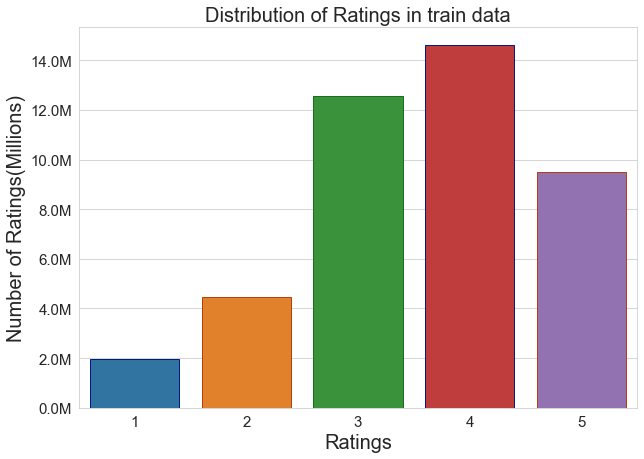

In [16]:
plt.figure(figsize = (10, 7))
da=Train_Data.sort_values(by=['Ratings'])
ax = sns.countplot(x="Ratings", data=da,edgecolor=sns.color_palette("dark", 3)
                  )

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Millions)", fontsize = 20)
plt.show()

In [17]:
Train_Data["DayOfWeek"] = Train_Data.Date.dt.day_name()

In [18]:
Train_Data.sample(3)

,MovieID,CustID,Ratings,Date,DayOfWeek
14351044,6555,2417042,2,2004-05-19,Wednesday
21952153,16977,1101683,3,2004-11-03,Wednesday
26893083,7767,1147880,5,2005-01-20,Thursday


#### Number of Ratings per month

<ipython-input-19-c6e023b62bb7>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])


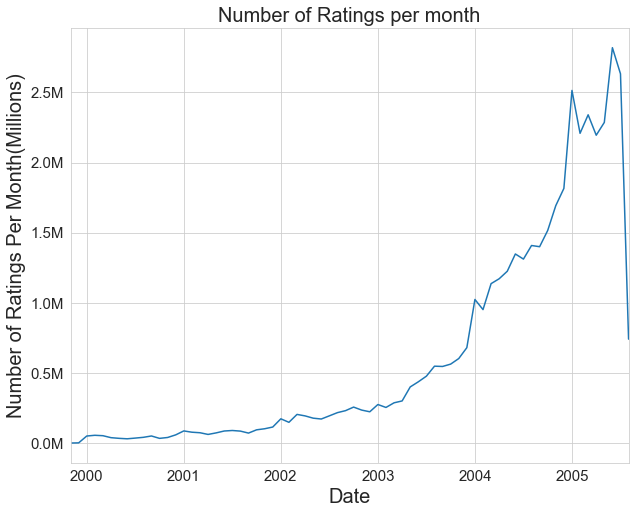

In [19]:
plt.figure(figsize = (10,8))
ax = Train_Data.resample("M", on = "Date")["Ratings"].count().plot()
#this above resample() function is a sort of group-by operation.Resample() function can work with dates. It can take months,
#days and years values independently. Here, in parameter we have given "M" which means it will group all the rows Monthly using 
#"Date" which is already present in the DataFrame. Now after grouping the rows month wise, we have just counted the ratings 
#which are grouped by months and plotted them. So, below plot shows that how many ratings are there per month. 
#In resample(), we can also give "6M" for grouping the rows every 6-Monthly, we can also give "Y" for grouping
#the rows yearly, we can also give "D" for grouping the rows by day.
#Resample() is a function which is designed to work with time and dates.
#This "Train_Data.resample("M", on = "Date")["Ratings"].count()" returns a pandas series where keys are Dates and values are 
#counts of ratings grouped by months.You can even check it and print it. Then we are plotting it, where it automatically takes
#Dates--which are keys on--x-axis and counts--which are values on--y-axis.
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

#### Analysis of Ratings given by user

In [20]:
no_of_rated_movies_per_user = Train_Data.groupby(by = "CustID")["Ratings"].count().sort_values(ascending = False)

no_of_rated_movies_per_user.sample(3)

CustID
952874      74
2154299    223
2164578     11
Name: Ratings, dtype: int64

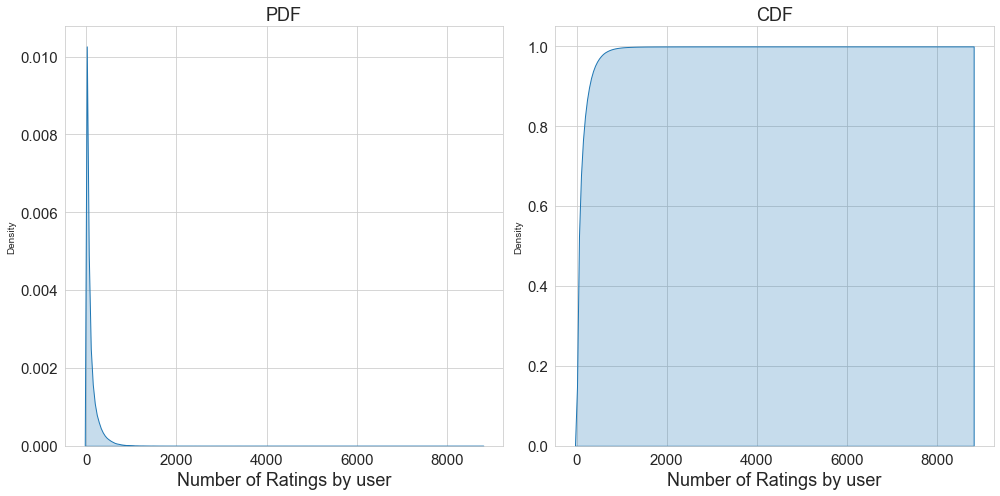

In [21]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

* Above PDF graph shows that almost all of the users give very few ratings. There are very few users who's ratings count is high.
* Similarly, above CDF graph shows that almost 99% of users give very few ratings.

In [22]:
print("Information about movie ratings grouped by users:")
no_of_rated_movies_per_user.describe()

Information about movie ratings grouped by users:


count    401901.00000
mean        107.14104
std         155.05350
min           1.00000
25%          19.00000
50%          48.00000
75%         133.00000
max        8779.00000
Name: Ratings, dtype: float64

In [23]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01))

In [24]:
quantiles[::5]

0.00       1.0
0.05       4.0
0.10       8.0
0.15      12.0
0.20      15.0
0.25      19.0
0.30      23.0
0.35      27.0
0.40      33.0
0.45      40.0
0.50      48.0
0.55      59.0
0.60      72.0
0.65      88.0
0.70     108.0
0.75     133.0
0.80     166.0
0.85     213.0
0.90     281.0
0.95     404.0
1.00    8779.0
Name: Ratings, dtype: float64

<ipython-input-25-7a0c4ff353df>:14: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = '({},{})'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 16, xytext=(x-0.05, y+180))


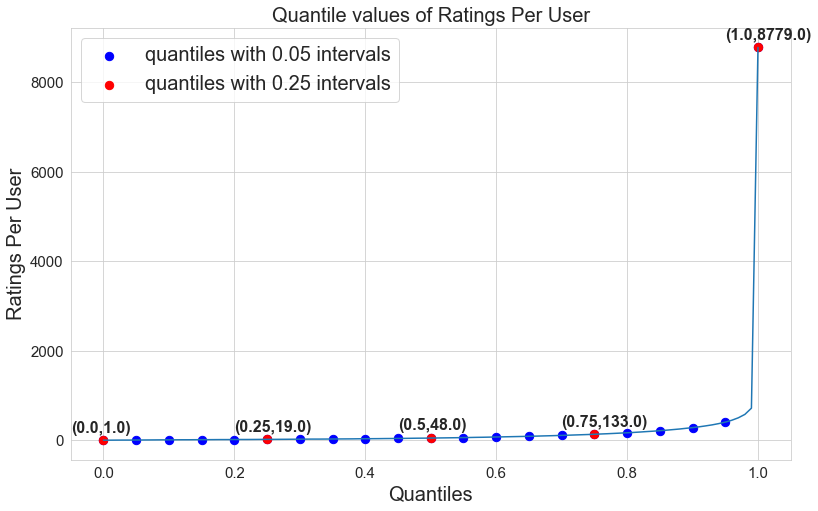

In [25]:
fig = plt.figure(figsize = (10, 6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of Ratings Per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red", s = 70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s = '({},{})'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 16, xytext=(x-0.05, y+180))
    
axes.tick_params(labelsize = 15)

In [26]:
print("Total number of ratings below 75th percentile = "+str(sum(no_of_rated_movies_per_user.values<=133)))
print("Total number of ratings above 75th percentile = "+str(sum(no_of_rated_movies_per_user.values>133)))

Total number of ratings below 75th percentile = 301857
Total number of ratings above 75th percentile = 100044


#### Analysis of Ratings Per Movie

In [27]:
no_of_ratings_per_movie = Train_Data.groupby(by = "MovieID")["Ratings"].count().sort_values(ascending = False)

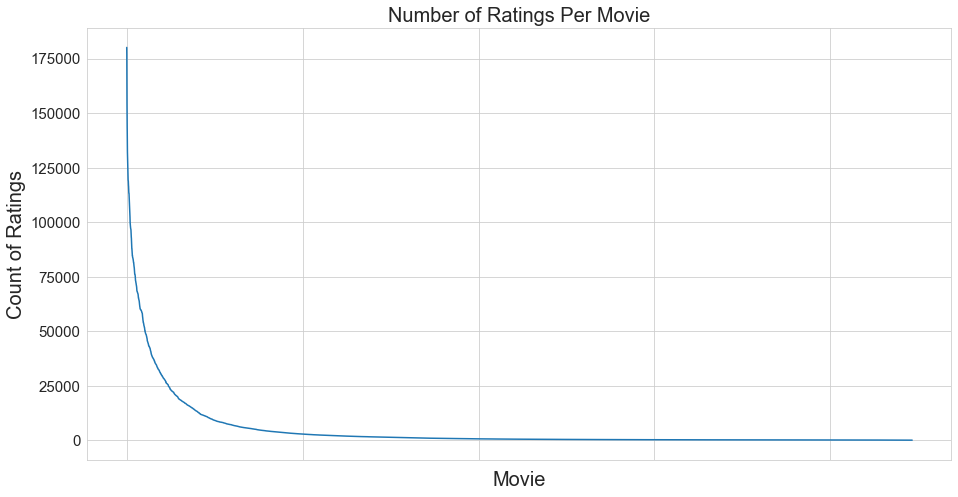

In [28]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

* It is very skewed

* It clearly shows that there are some movies which are very popular and were rated by many users as comapared to other movies

#### Analysis of Movie Ratings on Day of Week

<ipython-input-29-fe08a8216215>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])


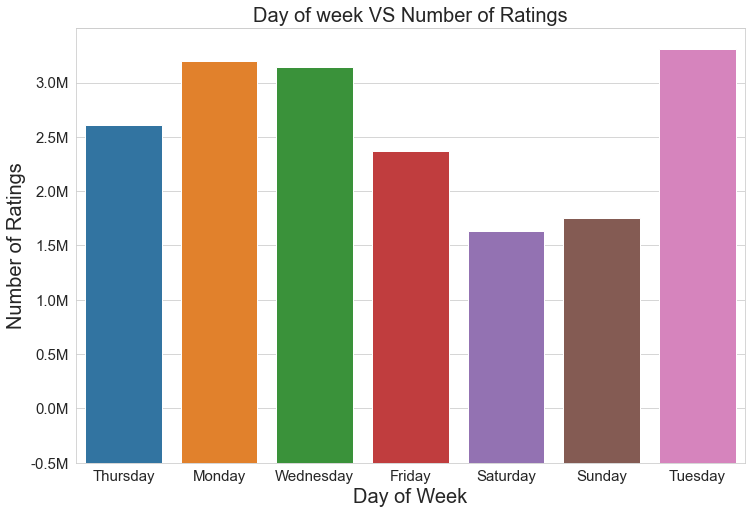

In [29]:
fig = plt.figure(figsize = (12, 8))

axes = sns.countplot(x = "DayOfWeek", data = Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
axes.tick_params(labelsize = 15)

plt.show()

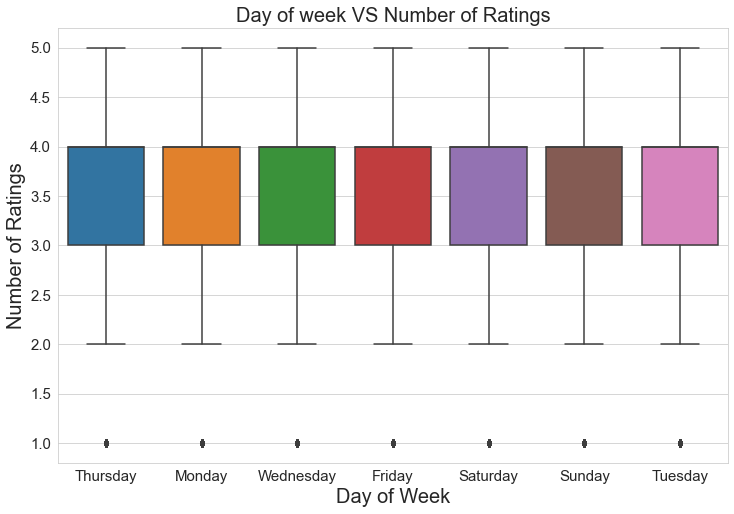

In [30]:
fig = plt.figure(figsize = (12, 8))

axes = sns.boxplot(x = "DayOfWeek", y = "Ratings", data = Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.tick_params(labelsize = 15)

plt.show()

In [31]:
average_ratings_dayofweek = Train_Data.groupby(by = "DayOfWeek")["Ratings"].mean()
print("Average Ratings on Day of Weeks")
print(average_ratings_dayofweek)

Average Ratings on Day of Weeks
DayOfWeek
Friday       3.589555
Monday       3.577235
Saturday     3.595120
Sunday       3.596637
Thursday     3.583570
Tuesday      3.574852
Wednesday    3.585002
Name: Ratings, dtype: float64


### 3. Creating USER-ITEM sparse matrix from data frame

In [32]:
%%time 
print("Creating USER_ITEM sparse matrix for train Data")
if os.path.isfile("./Data/TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz("./Data/TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))
    
else:
    print("We are creating sparse data")
    TrainUISparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.CustID, Train_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("./Data/TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

Creating USER_ITEM sparse matrix for train Data
Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix
Shape of Train Sparse matrix = (2649430, 17771)
Wall time: 1.25 s


In [33]:
%%time
print("Creating USER_ITEM sparse matrix for test Data")
if os.path.isfile("./Data/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz("./Data/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix = "+str(TestUISparseData.shape))
else:
    print("We are creating sparse data")
    TestUISparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.CustID, Test_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("./Data/TestUISparseData.npz", TestUISparseData)
    print("Done\n")

Creating USER_ITEM sparse matrix for test Data
Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix
Shape of Test Sparse Matrix = (2649430, 17771)
Wall time: 331 ms


* If you can see above that the shape of both train and test sparse matrices are same, furthermore, how come this shape of sparse matrix has arrived:
* Shape of sparse matrix depends on highest value of User ID and highest value of Movie ID. 
* Now the user whose user ID is highest is present in both train data and test data. Similarly, the movie whose movie ID is
* highest is present in both train data and test data. Hence, shape of both train and test sparse matrices are same.

In [34]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.90854433187319% 
Sparsity Of Test matrix : 99.97713608243731% 


### Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [35]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  #this will give an array of sum of all the ratings of user if axis = 1 else 
    #sum of all the ratings of movies if axis = 0
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  #this will give a boolean True or False array, and True means 1 and False 
    #means 0, and further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

#### Global Average Rating

In [36]:
Global_Average_Rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

Global Average Rating 3.5844935859517806


#### Average Rating Per User

In [37]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)

print("Average rating of user 25 = {}".format(AvgRatingUser[25]))

Average rating of user 25 = 3.0


In [38]:
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)

print("Average rating of movie 4500 = {}".format(AvgRatingMovie[4500]))

Average rating of movie 4500 = 3.28


### PDF and CDF of Average Ratings of Users and Movies

C:\Users\DEV\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\DEV\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


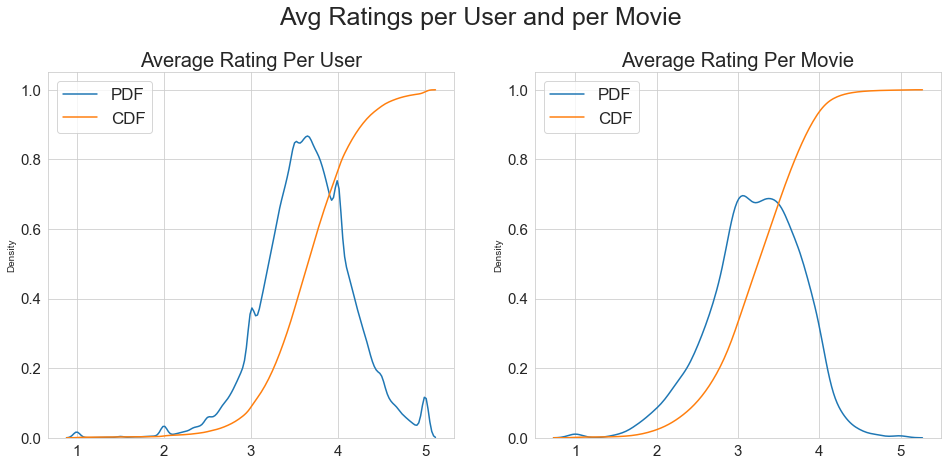

In [39]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=25)

user_average = [rats for rats in AvgRatingUser.values()]
sns.distplot(user_average, hist = False, ax = axes[0], label = "PDF")
sns.kdeplot(user_average, cumulative = True, ax = axes[0], label = "CDF")
axes[0].set_title("Average Rating Per User", fontsize=20)
axes[0].tick_params(labelsize = 15)
axes[0].legend(loc='upper left', fontsize = 17)

movie_average = [ratm for ratm in AvgRatingMovie.values()]
sns.distplot(movie_average, hist = False, ax = axes[1], label = "PDF")
sns.kdeplot(movie_average, cumulative = True, ax = axes[1], label = "CDF")
axes[1].set_title("Average Rating Per Movie", fontsize=20)
axes[1].tick_params(labelsize = 15)
axes[1].legend(loc='upper left', fontsize = 17)

plt.subplots_adjust(wspace=0.2, top=0.85)
plt.show()

### Cold Start Problem
#### Cold Start Problem with Users

In [40]:
total_users = len(np.unique(Final_Data["CustID"]))
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users
                  
print("Total number of Users = {}".format(total_users))
print("Number of Users in train data= {}".format(train_users))
print("Number of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total number of Users = 478723
Number of Users in train data= 401901
Number of Users not present in train data = 76822(16.0%)


#### Cold Start Problem with Movies

In [41]:
total_movies = len(np.unique(Final_Data["MovieID"]))
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies
                  
print("Total number of Movies = {}".format(total_movies))
print("Number of Movies in train data= {}".format(train_movies))
print("Number of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total number of Movies = 9114
Number of Movies in train data= 8931
Number of Movies not present in train data = 183(2.0%)


### 4. Computing Similarity Matrices
### Computing User-User Similarity Matrix
- Calculating User User Similarity_Matrix is __not very easy__(_unless you have huge Computing Power and lots of time_)

In [42]:
row_index, col_index = TrainUISparseData.nonzero()
rows = np.unique(row_index)
for i in rows[:100]:
    print(i,end=",")

6,7,10,25,33,42,59,79,83,87,94,97,131,134,142,149,158,168,169,178,183,188,189,192,195,199,201,242,247,248,261,265,266,267,268,283,291,296,298,299,301,302,304,305,307,308,310,312,314,330,331,333,352,363,368,369,379,383,384,385,392,413,416,424,437,439,440,442,453,462,470,471,477,478,479,481,485,490,491,492,495,508,515,517,527,529,536,540,544,546,550,561,576,585,592,596,602,609,614,616,

In [43]:
%%time
#Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating 
#top 100 most similar users with them.
def getUser_UserSimilarity(sparseMatrix, top = 100):
    startTimestamp20 = datetime.now()  
    
    row_index, col_index = sparseMatrix.nonzero()  #this will give indices of rows in "row_index" and indices of columns in 
    #"col_index" where there is a non-zero value exist.
    rows = np.unique(row_index)
    similarMatrix = np.zeros(61700).reshape(617,100)    # 617*100 = 61700. As we are building similarity matrix only 
    #for top 100 most similar users.
    timeTaken = []
    howManyDone = 0
    for row in rows[:top]:
        howManyDone += 1
        startTimestamp = datetime.now().timestamp()  #it will give seconds elapsed
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top100_similar_indices = sim.argsort()[-top:]
        top100_similar = sim[top100_similar_indices]
        similarMatrix[row] = top100_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 user = "+str(sum(timeTaken)/len(timeTaken))+"seconds")
    
    fig = plt.figure(figsize = (12,8))
    plt.plot(timeTaken, label = 'Time Taken For Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('Users', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()
    
    return similarMatrix

Wall time: 0 ns


Time elapsed for 20 users = 0:00:26.925632sec
Time elapsed for 40 users = 0:00:51.512204sec
Time elapsed for 60 users = 0:01:14.806471sec
Time elapsed for 80 users = 0:01:38.306770sec
Time elapsed for 100 users = 0:02:02.379479sec
Average Time taken to compute similarity matrix for 1 user = 1.2112620854377747seconds


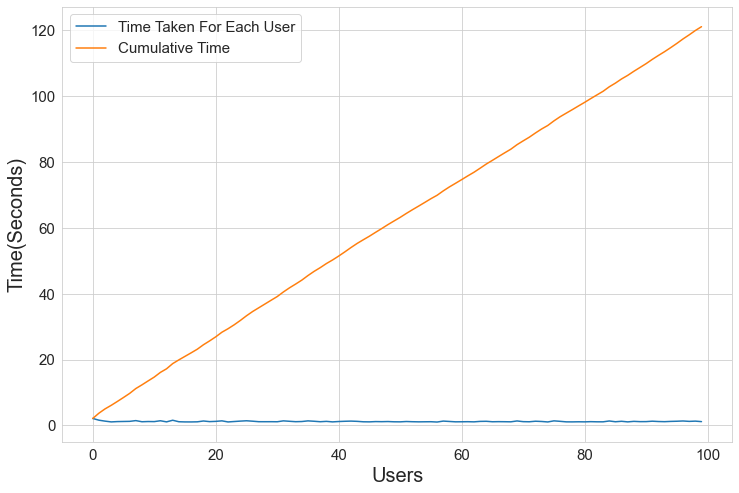

In [44]:
simMatrix = getUser_UserSimilarity(TrainUISparseData, 100)

We have __401901 Users__ in our training data.

Average time taken to compute similarity matrix for one user is 1.21 sec.__

For 401901 users:

_401901*1.21 == 1460910.135sec == 405.808hours ~ 17Days_

Computation of user-user similarity matrix is impossible if computational power is limited. On the other hand, if we try to reduce the dimension say by truncated SVD then it would take even more time because truncated SVD creates dense matrix and amount of multiplication for creation of user-user similarity matrix would increase dramatically.

__Is there any other way to compute user-user similarity???__

We maintain a binary Vector for users, which tells us whether we already computed similarity for this user or not..

__OR__

Compute top (let's just say, 1000) most similar users for this given user, and add this to our datastructure, so that we can just access it(similar users) without recomputing it again.

__If it is already computed__

Just get it directly from our datastructure, which has that information. In production time, We might have to recompute similarities, if it is computed a long time ago. Because user preferences changes over time. If we could maintain some kind of Timer, which when expires, we have to update it ( recompute it ).

Which datastructure to use:

It is purely implementation dependant.

One simple method is to maintain a **Dictionary Of Dictionaries**.

key : userid
value : Again a dictionary
key : _Similar User
value: Similarity Value>

In [45]:
start = datetime.now()

if not os.path.isfile("./Data/m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    print("Done")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz("./Data/m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz("./Data/m_m_similarity.npz")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    
print(datetime.now() - start)

File exists in the disk. Loading the file...
Dimension of Matrix = (17771, 17771)
0:00:04.152953


#### Does Movie-Movie Similarity Works?
- Let's pick random movie and check it's top 10 most similar movies.

In [46]:
movie_ids = np.unique(m_m_similarity.nonzero())

In [47]:
similar_movies_dict = dict()
for movie in movie_ids:
    smlr = np.argsort(-m_m_similarity[movie].toarray().ravel())[1:100]
    similar_movies_dict[movie] = smlr

In [48]:
similar_movies_dict

{4500: array([16987,  5989,  7908, 13982,  7323,  8090, 13862,  6307,  6749,
        16191,  5585,  5476,  8462,  5605,  8805,  4965,  8737, 15607,
         5262, 17740,  8604, 15016, 13855,  6310, 16720,  7912,  7925,
         8335, 17184, 13816,  8778,  4620, 14445, 15608, 15303,  5998,
        17389,  8093, 17732, 16914, 15239, 13377,  7787, 15214, 14939,
        15250,  8274,  4955,  6476,  9034,  8843,  8951, 16651,  7286,
        17460, 17117, 14828, 14293,  7774,  7594, 14967,  8318,  6457,
         8961, 15786,  8790, 13404, 16005, 13623, 15085, 14161, 14258,
         5546, 16321, 13901,  7614, 14599, 16689,  6226,  8634,  7960,
         7132, 14704, 13388,  8581,  4770, 13811,  5620, 17093, 16753,
         5662,  8685,  8681,  4562, 17244,  8727, 17619,  5134,  8410],
       dtype=int64),
 4501: array([14585, 16906,  6396,  8294, 15513,  6584,  5467, 14580,  7342,
        13805,  8412,  7542,  6790,  8994,  4578,  5194, 14003, 13640,
        17175,  6917,  7998, 17292, 16040, 

In [49]:
movie_titles_df = pd.read_csv("./Data/movie_titles.csv",sep = ",", header = None, names=['MovieID', 'Year_of_Release', 'Movie_Title'], index_col = "MovieID", encoding = "iso8859_2")
movie_titles_df[movie_titles_df['Movie_Title']=='Shrek 2']

,Year_of_Release,Movie_Title
MovieID,,
3938,2004.0,Shrek 2


#### Similar Movies to: Alien Hunter

In [50]:
movieID_GR=  17770
print("Name of the movie -------> "+str(movie_titles_df.loc[movieID_GR][1]))

print("Number of ratings by users for movie {} is {}".format(movie_titles_df.loc[movieID_GR][1], TrainUISparseData[:,movieID_GR].getnnz()))

print("Number of similar movies to {} is {}".format(movie_titles_df.loc[movieID_GR][1], m_m_similarity[movieID_GR].count_nonzero()))

Name of the movie -------> Alien Hunter
Number of ratings by users for movie Alien Hunter is 796
Number of similar movies to Alien Hunter is 8870


In [51]:
all_similar = sorted(m_m_similarity[movieID_GR].toarray().ravel(), reverse = True)[1:]

similar_100 = all_similar[:101]

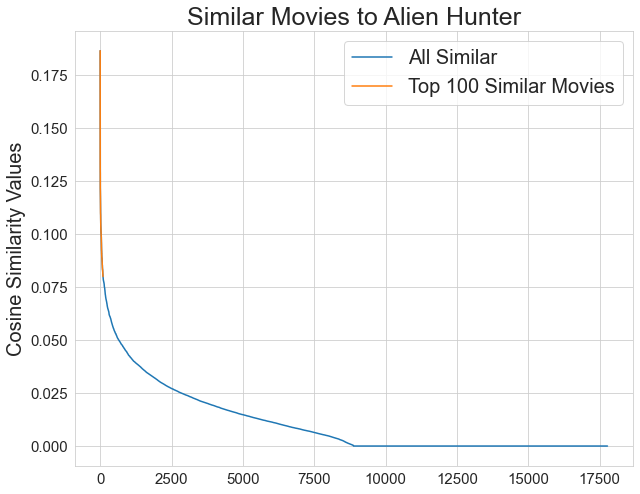

In [52]:
plt.figure(figsize = (10, 8))
plt.plot(all_similar, label = "All Similar")
plt.plot(similar_100, label = "Top 100 Similar Movies")
plt.title("Similar Movies to Alien Hunter", fontsize = 25)
plt.ylabel("Cosine Similarity Values", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 20)
plt.show()

In [53]:
# Top 10 similar movies to Epoch

movie_titles_df.loc[similar_movies_dict[movieID_GR][:10]]

,Year_of_Release,Movie_Title
MovieID,,
17768,2000.0,Epoch
16759,1991.0,Eve of Destruction
16348,1998.0,The Arrival / The Arrival 2
5893,2001.0,Lost Voyage
8152,1983.0,Strange Invaders
8471,1999.0,NetForce
15377,1998.0,Deep Rising
7486,2003.0,Absolon
17287,1989.0,Millennium


- if,you see the generes of movies then, it seems that Movie-Movie similarity is working perfectly.

### 5. Machine Learning Models

In [54]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    startTime = datetime.now()
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15)   #this will give same random number everytime, without replacement
    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(userS)+1, max(movieS)+1))
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(path, sparse_sample)
    print("Done")
    print("Shape of Sparse Sampled Matrix = "+str(sparse_sample.shape))
    
    print(datetime.now() - start)
    return sparse_sample

#### Creating Sample Sparse Matrix for Train Data

In [55]:
%%time
path = "./Data/TrainUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 4000, 400)
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Train Sample Sparse Matrix = "+str(train_sample_sparse.shape))

File is already present in the disk. Loading the file...
File loading done.
Shape of Train Sample Sparse Matrix = (2649117, 17764)
Wall time: 21 ms


#### Creating Sample Sparse Matrix for Test Data

In [56]:
%%time
path = "./Data/TestUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200)
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Test Sample Sparse Matrix = "+str(test_sample_sparse.shape))

File is already present in the disk. Loading the file...
File loading done.
Shape of Test Sample Sparse Matrix = (2647588, 17689)
Wall time: 18 ms


#### Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)

In [57]:
print("Global average of all movies ratings in Train Sample Sparse is {}".format(np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)))

Global average of all movies ratings in Train Sample Sparse is 3.58


- Finding Average of all movie ratings

In [58]:
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
print("Average move rating for movie 14890 is {}".format(globalAvgMovies[14890]))

Average move rating for movie 14890 is 3.2870967741935484


- Finding Average rating per User

In [59]:
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Average user rating for user 16879 is {}".format(globalAvgMovies[16879]))

Average user rating for user 16879 is 3.738095238095238


#### Featurizing data

In [60]:
print("No of ratings in Our Sampled train matrix is : {}".format(train_sample_sparse.count_nonzero()))
print("No of ratings in Our Sampled test matrix is : {}".format(test_sample_sparse.count_nonzero()))

No of ratings in Our Sampled train matrix is : 19214
No of ratings in Our Sampled test matrix is : 1150


### Featurizing data for regression problem

#### Featurizing Train Data

In [61]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(train_sample_sparse)

In [62]:
%%time
if os.path.isfile("./Data/Train_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Train csv file for {} rows".format(len(sample_train_ratings)))
    with open("./Data/Train_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            row = list()
            row.append(user)  #appending user ID
            row.append(movie) #appending movie ID
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
            similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
            row.extend(top_similar_user_ratings)
            
 #----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
            similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_movie_ratings)
            
 #----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
            row.append(globalAvgUsers[user])
            row.append(globalAvgMovies[movie])
            row.append(rating)
            
#-----------------------------------Converting rows and appending them as comma separated values to csv file------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 2000 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_train_ratings), (datetime.now() - startTime)))

File is already present in your disk. You do not have to prepare it again.
Wall time: 1 ms


In [63]:
Train_Reg = pd.read_csv("./Data/Train_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Train_Reg.sample(3)

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
7495,423952,7645,3.582804,3.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,3.0,2.0,3.310345,3.711340,3
12436,668443,15058,3.582804,4.0,5.0,3.0,4.0,4.0,3.0,5.0,5.0,5.0,4.6,4.600000,3.553872,5
904,2241090,4972,3.582804,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,3.4,3.400000,3.416555,4


In [64]:
print("Number of nan Values = "+str(Train_Reg.isnull().sum().sum()))

Number of nan Values = 0


<p><b>User_ID:</b> ID of a this User</p>

<p><b>Movie_ID:</b> ID of a this Movie</p>

<p><b>Global_Average:</b> Global Average Rating</p>

<p><b>Ratings given to this Movie by top 5 similar users with this User:</b> (SUR1, SUR2, SUR3, SUR4, SUR5)</p>
   
<p><b>Ratings given by this User to top 5 similar movies with this Movie:</b> (SMR1, SMR2, SMR3, SMR4, SMR5)</p>

<p><b>User_Average:</b> Average Rating of this User</p>

<p><b>Movie_Average:</b> Average Rating of this Movie</p>

<p><b>Rating:</b> Rating given by this User to this Movie</p>

In [65]:
print("Shape of Train DataFrame = {}".format(Train_Reg.shape))

Shape of Train DataFrame = (19214, 16)


#### Featurizing Test Data


In [66]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(test_sample_sparse)

In [67]:
if os.path.isfile("./Data/Test_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Test csv file for {} rows".format(len(sample_test_ratings)))
    with open("./Data/Test_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            row = list()
            row.append(user)  #appending user ID
            row.append(movie) #appending movie ID
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#-----------------------------Ratings given to "movie" by top 5 similar users with "user"-------------------------#
            try:
                similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
                similar_users_indices = np.argsort(-similar_users)[1:]
                similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
                top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
                top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
                row.extend(top_similar_user_ratings)
            #########Cold Start Problem, for a new user or a new movie#########    
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Ratings given by "user" to top 5 similar movies with "movie"-----------------------#
            try:
                similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
                similar_movies_indices = np.argsort(-similar_movies)[1:]
                similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
                top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
                top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
                row.extend(top_similar_movie_ratings)
            #########Cold Start Problem, for a new user or a new movie#########
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Appending "user" average, "movie" average & rating of "user""movie"----------------#
            try:        
                row.append(globalAvgUsers[user])
            except (KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            try:
                row.append(globalAvgMovies[movie])
            except(KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            row.append(rating)
            
#------------------------------Converting rows and appending them as comma separated values to csv file-----------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 100 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_test_ratings), (datetime.now() - startTime)))

File is already present in your disk. You do not have to prepare it again.


In [68]:
Test_Reg = pd.read_csv("./Data/Test_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Test_Reg.sample(3)

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
662,1936883,8584,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,4
730,334847,13905,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3
540,1815614,7713,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,2


In [69]:
print("Number of nan Values = "+str(Test_Reg.isnull().sum().sum()))
print("Shape of Test DataFrame = {}".format(Test_Reg.shape))

Number of nan Values = 0
Shape of Test DataFrame = (1150, 16)


### Transforming Data for Surprise Models
#### Transforming Train Data
- We can't give raw data (movie, user, rating) to train the model in Surprise library.


- They have a separate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.


- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

### Transforming Data for Surprise Models
#### Transforming Train Data
- We can't give raw data (movie, user, rating) to train the model in Surprise library.


- They have a separate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.


- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

In [70]:
Train_Reg[['User_ID', 'Movie_ID', 'Rating']].head(3)

,User_ID,Movie_ID,Rating
0,180921,4512,1
1,210185,4512,2
2,218038,4512,4


In [71]:
reader = Reader(rating_scale=(1, 5)) #Reader class is used to parse a file containing ratings

data = Dataset.load_from_df(Train_Reg[['User_ID', 'Movie_ID', 'Rating']], reader)

trainset = data.build_full_trainset()

#### Transforming Test Data

- For test data we just have to define a tuple (user, item, rating).
- You can check out this link: https://github.com/NicolasHug/Surprise/commit/86cf44529ca0bbb97759b81d1716ff547b950812
- Above link is a github of surprise library. Check methods "def all_ratings(self)" and "def build_testset(self)" from line
  177 to 201(If they modify the file then line number may differ, but you can always check aforementioned two methods).
- "def build_testset(self)" method returns a list of tuples of (user, item, rating).

In [72]:
testset = list(zip(Test_Reg["User_ID"].values, Test_Reg["Movie_ID"].values, Test_Reg["Rating"].values))

In [73]:
testset[:5]

[(464626, 4614, 3),
 (1815614, 4627, 3),
 (2298717, 4627, 5),
 (2532402, 4627, 4),
 (2027, 4798, 5)]

### Applying Machine Learning Models
<p>We have two Error Metrics.</p>
<p><b> -  RMSE: Root Mean Square Error: </b>RMSE is the error of each point which is squared. Then mean is calculated. Finally root of that mean is taken as final value.</p>
<p><b> -   MAPE: Mean Absolute Percentage Error: </b>The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method.</p>
<p><center>where At is the actual value and Ft is the forecast value.</p>
<p>
The difference between At and Ft is divided by the actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.</p>

In [74]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [75]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    #All variable assignments in a function store the value in the local symbol table; whereas variable references first look 
    #in the local symbol table, then in the global symbol table, and then in the table of built-in names. Thus, global variables 
    #cannot be directly assigned a value within a function (unless named in a global statement), 
    #although they may be referenced.
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

#### Utility Functions for Regression Models

In [76]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

In [77]:
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name,n_estimators=100):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    rmse_train= {}
    mape_train= {}
    rmse_test= {}
    mape_test= {}
    clf = xgb.XGBRegressor(n_estimators =n_estimators , silent = False, n_jobs  = 10
                          ,tree_method='gpu_hist')
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MAPE = {}".format(mape_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MAPE = {}".format(mape_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
        
    print("Time Taken = "+str(datetime.now() - startTime))
    
    plot_importance(xgb, clf)
    
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    
    return train_result, test_result

In [78]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

#### Utility Functions for Surprise Models

In [79]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted
#in surprise prediction of every data point is returned as dictionary 
# like this:
#"user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
#In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating 

In [80]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [81]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    #You can check out above function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    #You can check out "trainset.build_testset()" function at "https://surprise.readthedocs.io/en/stable/FAQ.html#can-i-use-my-own-dataset-with-surprise-and-can-it-be-a-pandas-dataframe" in 
    #"How to get accuracy measures on the training set" section
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    print("TEST DATA")
    test_pred = algo.test(testset)
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test

#### 1. XGBoost 13 Features

[09:55:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.634731342045909
MAPE = 17.66577661037445
--------------------------------------------------
TEST DATA
RMSE = 1.0782390966108895
MAPE = 34.62885143825951
--------------------------------------------------
Time Taken = 0:00:02.167684


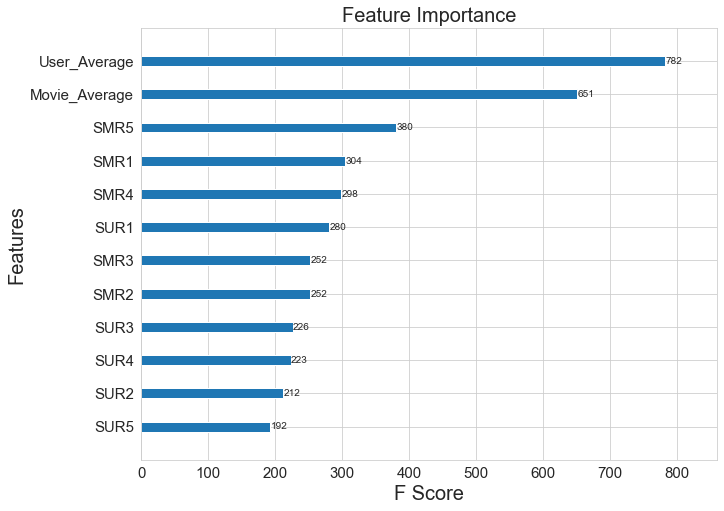

In [82]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]


train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13"
                                             ,70 )

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

### 2. Surprise BaselineOnly Model
#### Predicted Rating:
> $\large\hat{r}_{ui} = \mu + b_u + b_i$<br><br>

- $\mu$: Average Global Ratings in training data<br>
- $b_u$: User-Bias<br>
- $b_i$: Item-Bias

#### Optimization Function:
> $\large \sum_{r_ui \in R_{Train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 + \lambda \left(b_u^2 + b_i^2 \right). \left[minimize\; b_u, b_i \right]$

In [83]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":1000}

algo = BaselineOnly(bsl_options=bsl_options)
#You can check the docs of above used functions at:https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration
#at section "Baselines estimates configuration".

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8488356630664367
MAPE = 25.056283892927805
--------------------------------------------------
TEST DATA
RMSE = 1.067550271812548
MAPE = 33.38764696450425
--------------------------------------------------
Time Taken = 0:00:03.486788


### 3. XGBoost 13 Features + Surprise BaselineOnly Model
#### Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

In [84]:
Train_Reg["BaselineOnly"] = model_train_evaluation["BaselineOnly"]["Prediction"]
Train_Reg.sample(3)


,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly
10392,2199685,14670,3.582804,4.0,3.0,5.0,3.0,5.0,4.0,5.0,3.0,5.0,5.0,3.954545,3.668874,4,2.736358
3438,862557,6029,3.582804,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,3.0,3.2,3.200000,4.024079,3,2.760839
16295,392651,16565,3.582804,3.0,4.0,3.0,5.0,3.0,4.0,4.0,4.0,5.0,3.0,3.081081,3.434243,3,3.286856


In [85]:
print("Number of nan values = "+str(Train_Reg.isnull().sum().sum()))

Test_Reg["BaselineOnly"] = model_test_evaluation["BaselineOnly"]["Prediction"]
Test_Reg.sample(3)


Number of nan values = 0


,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly
827,2620151,14050,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,4,3.582804
741,232758,14050,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3,3.582804
1048,364749,15979,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3,3.582804


In [86]:
print("Number of nan values = "+str(Test_Reg.isnull().sum().sum()))

Number of nan values = 0


[09:55:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.5849015484063695
MAPE = 16.01957529783249
--------------------------------------------------
TEST DATA
RMSE = 1.1692635357301566
MAPE = 38.434345845899635
--------------------------------------------------
Time Taken = 0:00:00.708159


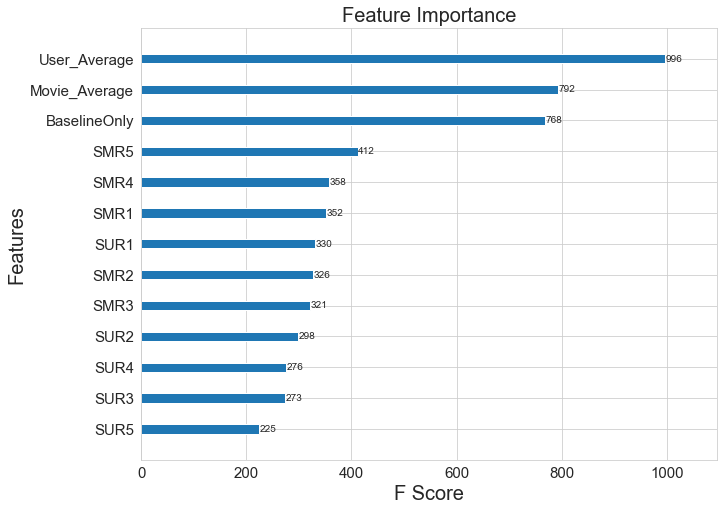

In [87]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

### 4. Surprise KNN-Baseline with User-User and Item-Item Similarity
#### Prediction $\hat{r}_{ui}$ in case of user-user similarity

$\large \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v
\in N^k_i(u)} \text{sim}(u, v)}$

- $\pmb{b_{ui}}$ - Baseline prediction_ of (user,movie) rating which is "$b_{ui} = \mu + b_u + b_i$".

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - Similarity between users __u and v__ who also rated movie 'i'. This is exactly same as our hand-crafted features 'SUR'- 'Similar User Rating'. Means here we have taken 'k' such similar users 'v' with user 'u' who also rated movie 'i'. $r_{vi}$ is the rating which user 'v' gives on item 'i'. $b_{vi}$ is the predicted baseline model rating of user 'v' on item 'i'.
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take     - base line predictions instead of mean rating of user/item)<br><br><br><br>  

### Prediction $\hat{r}_{ui}$ in case of item-item similarity

$\large \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}
\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in
N^k_u(j)} \text{sim}(i, j)}$

- __Notation is same as of user-user similarity__<br><br><br>


#### Documentation you can check at:
KNN BASELINE: https://surprise.readthedocs.io/en/stable/knn_inspired.html

PEARSON_BASELINE SIMILARITY: http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline

SHRINKAGE: Neighborhood Models in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf

#### 4.1 Surprise KNN-Baseline with User-User.
- Cross- Validation

In [89]:
param_grid  = {'sim_options':
               {
                    "name": ["pearson_baseline"],
                    "user_based": [True], 
                    "min_support": [2], 
                    "shrinkage": [60,80,100,120]
               }, 
                    "k": [5,20,40,50 ,80]
              }

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

#### Applying KNNBaseline User-User with best parameters


In [90]:
sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}
bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_User")

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.3044975188091617
MAPE = 8.090955152033715
--------------------------------------------------
TEST DATA
RMSE = 1.067654798722828
MAPE = 33.39814334762251
--------------------------------------------------
Time Taken = 0:00:09.208082


### 4.2 Surprise KNN-Baseline with Item-Item.
- Cross- Validation

In [91]:
param_grid  = {'sim_options':
                   {
                   'name': ["pearson_baseline"], 
                    "user_based": [False], 
                    "min_support": [6,10,12,14,16], 
                    "shrinkage": [60, 80, 80, 140]
                   }, 
               'k': [5, 20, 40, 80]
              }

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

#### Applying KNNBaseline Item-Item with best parameters

In [92]:
sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':16, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.17383638257357706
MAPE = 3.8428966564970675
--------------------------------------------------
TEST DATA
RMSE = 1.067654798722828
MAPE = 33.39814334762251
--------------------------------------------------
Time Taken = 0:00:00.584131


#### 5. XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline
- Adding predicted ratings from Surprise KNN Baseline model to our Train and Test Dataframe

In [93]:
Train_Reg["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]
Train_Reg["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Item"]["Prediction"]

Test_Reg["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]
Test_Reg["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Item"]["Prediction"]

In [94]:
Train_Reg.sample(3)

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
12679,1727232,15058,3.582804,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,3.315789,3.553872,3,2.386580,2.333333,1.989197
18977,425692,17762,3.582804,4.0,4.0,3.0,2.0,2.0,2.0,2.0,5.0,4.0,5.0,3.500000,3.584615,3,4.942692,4.863139,4.972775
4774,1945634,6337,3.582804,4.0,4.0,4.0,2.0,4.0,4.0,3.0,3.0,5.0,4.0,3.714286,3.175510,3,3.229560,3.164242,3.172641


In [95]:
print("Number of nan values in Train Data "+str(Train_Reg.isnull().sum().sum()))

Number of nan values in Train Data 0


In [96]:
Test_Reg.sample(3)

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
695,1330553,9129,3.582804,4.000000,1.000000,4.000000,3.000000,3.000000,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.000000,3,3.426774,3.508343,3.508343
285,2016093,5401,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,4,3.582804,3.582804,3.582804
915,1747339,14218,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,4,3.582804,3.582804,3.582804


In [97]:
print("Number of nan values in Test Data "+str(Test_Reg.isnull().sum().sum()))

Number of nan values in Test Data 0


[10:00:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.8056759110180113
MAPE = 23.161311447620392
--------------------------------------------------
TEST DATA
RMSE = 1.1274710362260163
MAPE = 31.887953547809328
--------------------------------------------------
Time Taken = 0:00:00.126029


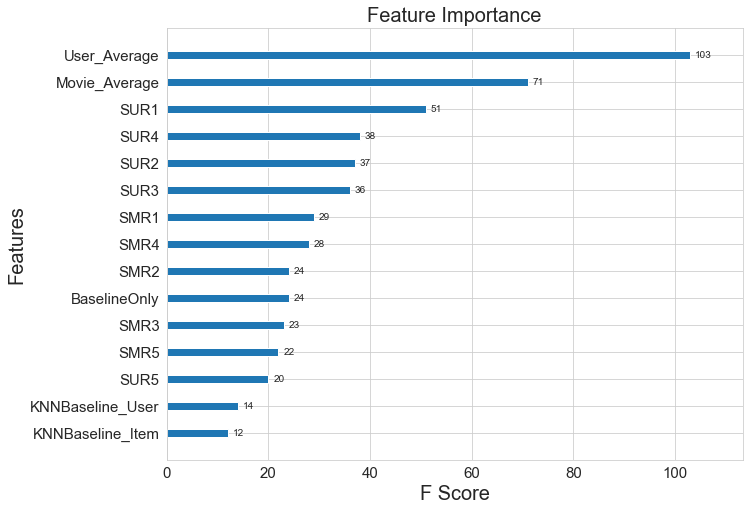

Wall time: 353 ms


In [98]:
%%time
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN"
                                              ,9 )

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

### 6. Matrix Factorization SVD
#### Prediction $\hat{r}_{ui}$ is set as:<br>

$\large \hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$
- $\pmb q_i$ - Representation of item(movie) in latent factor space
        
- $\pmb p_u$ - Representation of user in new latent factor space<br>

__If user u is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item i with $b_i$ and $q_i$.__<br><br><br>


#### Optimization Problem<br>

$\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) \left[minimize\; b_u, b_i, q_i, p_u \right]$
<br><br><br>

SVD Documentation: https://surprise.readthedocs.io/en/stable/matrix_factorization.html
- Cross Validation

In [151]:
param_grid  = {  'n_factors': [2,3,4,5,6,7,8,9,10]
                 
              }
# There, n_factors is the equivalent to dimension 'd' when matrix 'A' is-
# broken into 'b' and 'c'. 
# So, matrix 'A' will be of dimension n*m. 
# So, matrices 'b' and 'c' will be of dimension n*d and m*d.

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9920283202809856
{'n_factors': 2}


#### Applying SVD with best parameters

In [152]:
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, 
           verbose=True, n_epochs=50 )

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")
print('-'*78)

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
----------

### 7. Matrix Factorization SVDpp with implicit feedback
#### Prediction $\hat{r}_{ui}$ is set as:<br>
$\large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
|I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right)$<br><br>

 - $ \pmb{I_u}$ --- the set of all items rated by user u. $|I_u|$ is a length of that set.<br>

-  $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings. Here, an implicit rating describes the fact that a user u rated an item j, regardless of the rating value. $y_i$ is an item vector. For every item j, there is an item vector $y_j$ which is an implicit feedback. Implicit feedback indirectly reflects opinion by observing user behavior including purchase history, browsing history, search patterns, or even mouse movements. 
- Implicit feedback usually denotes the presence or absence of an event. For example, there is a movie 10 where user has just checked the details of the movie and spend some time there, will contribute to implicit rating.
- Now, since here Netflix has not provided us the details that for how long a user has spend time on the movie, so here we are considering the fact that even if a user has rated some movie then it means that he has spend some time on that movie which contributes to implicit rating.<br><br>

__If user u is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item i with $b_i$, $q_i$ and $y_i$.__<br><br>
#### Optimization Problem:
$\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right).\left[minimize\; b_u, b_i, q_i, p_u, y_j \right]$<br><br>

SVDpp Documentation: https://surprise.readthedocs.io/en/stable/matrix_factorization.html
- Cross-Validation


In [154]:
param_grid = {'n_factors': [10, 30, 50, 80], 
              'lr_all': [.004, .005, .006, .007 ,.008,]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9844458981332411
{'n_factors': 10, 'lr_all': 0.006}


#### Applying SVDpp with best parameters

In [157]:
algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True
            ,  n_epochs=50)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 20
 processing epoch 21
 processing epoch 22
 processing epoch 23
 processing epoch 24
 processing epoch 25
 processing epoch 26
 processing epoch 27
 processing epoch 28
 processing epoch 29
 processing epoch 30
 processing epoch 31
 processing epoch 32
 processing epoch 33
 processing epoch 34
 processing epoch 35
 processing epoch 36
 processing epoch 37
 processing epoch 38
 processing epoch 39
 processing epoch 40
 processing epoch 41
 processing epoch 42
 processing epoch 43
 processing epoch 44
 processing epoch 45
 processing epoch 46
 processing epoch 47
 p

### 8. XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

In [158]:
Train_Reg["SVD"] = model_train_evaluation["SVD"]["Prediction"]
Train_Reg["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]

Test_Reg["SVD"] = model_test_evaluation["SVD"]["Prediction"]
Test_Reg["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]

Train_Reg.sample(3)

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,...,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SVD,SVDpp
15405,1108724,15902,3.582804,4.0,5.0,5.0,5.0,3.0,5.0,4.0,...,4.0,5.0,4.333333,4.093897,5,3.000033,4.350825,4.598659,3.374817,4.128583
12111,1970422,14890,3.582804,4.0,4.0,3.0,4.0,5.0,5.0,3.0,...,4.0,4.2,4.200000,3.287097,4,3.076835,3.189740,3.152183,3.097474,3.185233
13097,1654496,15481,3.582804,2.0,2.0,4.0,3.0,3.0,1.0,3.0,...,4.0,3.0,3.172414,3.013514,2,4.292489,4.826294,4.966860,4.528433,4.719866


In [104]:
print("Number of nan values in Train Data "+str(Train_Reg.isnull().sum().sum()))

Number of nan values in Train Data 0


In [105]:
Test_Reg.head(3)

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,...,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SVD,SVDpp
0,464626,4614,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,...,3.582804,3.582804,3.582804,3.582804,3,3.582804,3.582804,3.582804,3.582804,3.582804
1,1815614,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,...,3.582804,3.582804,3.582804,3.582804,3,3.582804,3.582804,3.582804,3.582804,3.582804
2,2298717,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,...,3.582804,3.582804,3.582804,3.582804,5,3.582804,3.582804,3.582804,3.582804,3.582804


[11:11:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.8029417111827392
MAPE = 23.147085309028625
--------------------------------------------------
TEST DATA
RMSE = 1.1278253204735833
MAPE = 31.902603093092303
--------------------------------------------------
Time Taken = 0:00:00.109007


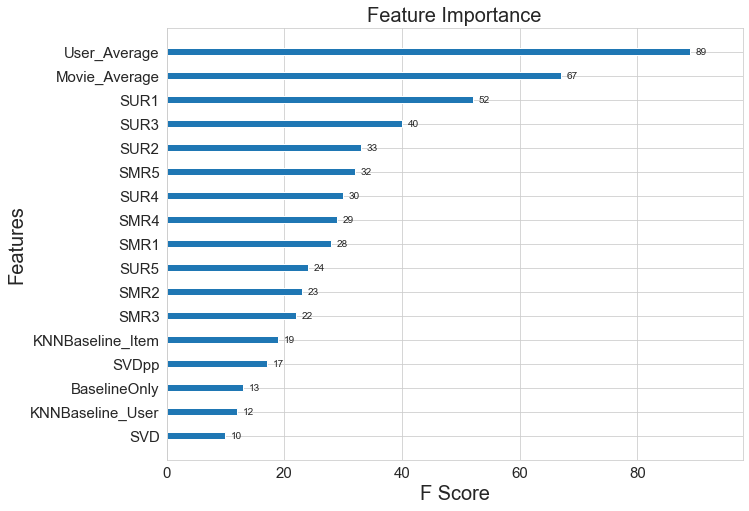

In [165]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test,
                                    "XGB_BSL_KNN_MF",9 )

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

### 9. Surprise KNN Baseline + SVD + SVDpp

[11:13:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.9893873719476131
MAPE = 32.19826817512512
--------------------------------------------------
TEST DATA
RMSE = 1.0695527202852466
MAPE = 33.42522413557846
--------------------------------------------------
Time Taken = 0:00:00.268043


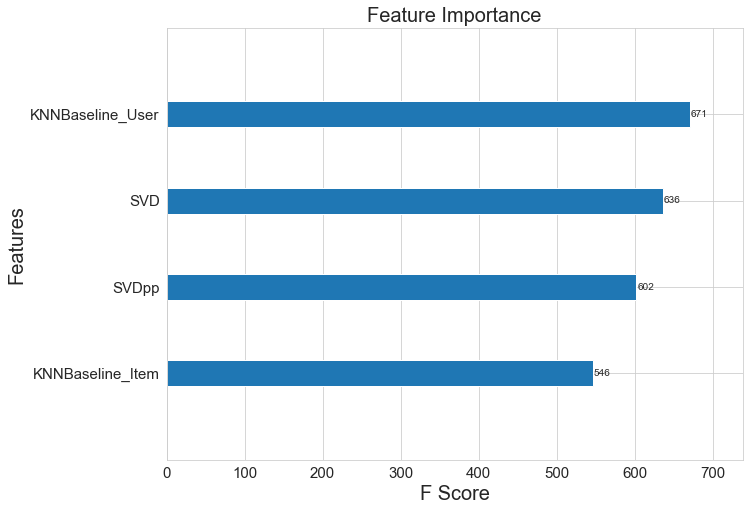

In [175]:
x_train = Train_Reg[["KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp"]]

x_test = Test_Reg[["KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp"]]

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, 
                                               "XGB_KNN_MF", 50)

model_train_evaluation["XGB_KNN_MF"] = train_result
model_test_evaluation["XGB_KNN_MF"] = test_result

### Summary

In [176]:
error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

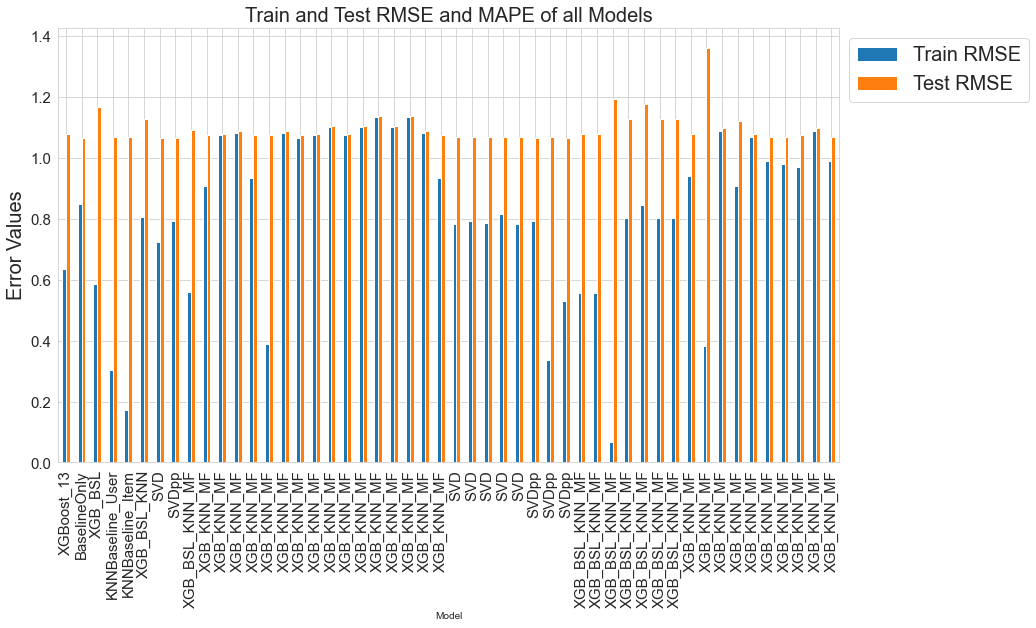

In [177]:
error_table2.plot(x = "Model", kind = "bar", figsize = (14, 8), grid=True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 20)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 20)
plt.show()

In [178]:
error_table.drop(["Train MAPE", "Test MAPE"], axis = 1).style.highlight_min(axis=0)

,Model,Train RMSE,Test RMSE
0,XGBoost_13,0.634731,1.078239
1,BaselineOnly,0.848836,1.067550
2,XGB_BSL,0.584902,1.169264
3,KNNBaseline_User,0.304498,1.067655
4,KNNBaseline_Item,0.173836,1.067655
5,XGB_BSL_KNN,0.805676,1.127471
6,SVD,0.725675,1.067523
7,SVDpp,0.791895,1.067596
8,XGB_BSL_KNN_MF,0.561539,1.091647
9,XGB_KNN_MF,0.906812,1.075937


### So, far our best model is SVDpp with Test RMSE of 1.067364